In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from urllib.parse import quote

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from imblearn.over_sampling import SMOTE  # For handling class imbalance


In [3]:
# Define connection parameters
server = 'localhost'
database = 'BritishAirwaysDB'
driver = 'ODBC Driver 17 for SQL Server'

# Connection string
connection_string = f"mssql+pyodbc:///?odbc_connect={quote(f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;')}"

try:
    # Establish a connection using pyodbc
    connection = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
    print("Connected successfully to the database.")

    # Execute a simple query to ensure everything is working
    cursor = connection.cursor()
    cursor.execute("SELECT @@version;")
    row = cursor.fetchone()
    if row:
        print("Database version:", row[0])

except pyodbc.Error as e:
    print("Error in connection:", e)

finally:
    # Close the connection if it was established
    if 'connection' in locals() and connection:
        connection.close()

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Query the table
query = "SELECT * FROM Reviews"
df = pd.read_sql(query, engine)


Connected successfully to the database.
Database version: Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) 
	Oct  8 2022 05:58:25 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows 10 Home Single Language 10.0 <X64> (Build 26100: ) (Hypervisor)



In [4]:

# Show First ten
OpenFile = df
FirstTen = OpenFile.head(10)
FirstTen

,Id,Rating,Author,Author Location,Review Date,Review Title,Review,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food And Beverages,Inflight Entertainment,Ground Service,Value For Money,Recommended Service
0,1,1.0,Bart Johnson,United States,2025-01-05,Not the best customer service,✅ Trip Verified | Not the best customer serv...,Couple Leisure,Economy Class,Monrovia to Washington via Addas Ababa,2025-01-01,1.0,3.0,1.0,0.0,2.0,2,no
1,2,2.0,H Thornton,United States,2025-01-03,Worst business class experience,✅ Trip Verified | Worst business class experie...,Business,Business Class,Addis Ababa to Toronto via Rome,2025-01-01,2.0,1.0,1.0,1.0,2.0,3,no
2,3,3.0,I Lee,United States,2024-12-17,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,Business,Economy Class,Addis Ababa to Nairobi,2024-12-01,1.0,1.0,3.0,0.0,3.0,3,no
3,4,1.0,Brenda Acan,United States,2024-12-16,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,Couple Leisure,Economy Class,Dubai to Zanzibar via Ethiopia,2024-12-01,1.0,1.0,1.0,1.0,1.0,1,no
4,5,3.0,Jillian Saltpaw,United States,2024-12-15,service fell painfully short,✅ Trip Verified | My recent journey from Was...,Couple Leisure,Economy Class,Washington IAD to Johannesburg,2024-12-01,2.0,2.0,1.0,3.0,1.0,1,no
5,6,1.0,E Basano,United States,2024-12-04,Ethiopian Airlines needs to do better,✅ Trip Verified | I just landed from an Ethi...,Solo Leisure,Economy Class,Addis Ababa to Washington via Lome,2024-11-01,2.0,2.0,1.0,1.0,2.0,1,no
6,7,4.0,M Larsen,United States,2024-12-01,I felt like I was back in the 90's,✅ Trip Verified | HKG-BKK-ADD-LAD-ADD-VIE-CPH ...,Solo Leisure,Economy Class,Hong Kong to Copenhagen via Luanda,2024-11-01,2.0,3.0,3.0,2.0,2.0,3,no
7,8,1.0,S Jiang,United States,2024-12-01,expected much more,✅ Trip Verified | Service was not there at a...,Couple Leisure,Economy Class,Tokyo to Seoul,2024-12-01,2.0,1.0,2.0,0.0,5.0,1,no
8,9,1.0,Gala Pate,United States,2024-11-29,the most uncomfortable flight,Not Verified | It was the most uncomfortable f...,Family Leisure,Economy Class,Atlanta GA to Lusaka Zambia via Addis Ababa,2023-12-01,1.0,1.0,1.0,1.0,1.0,1,no
9,10,4.0,R Adamski,United States,2024-11-01,didn’t like the flight or the service,✅ Trip Verified | The staff had a rather avera...,Business,Business Class,Hong Kong to Bangkok,2024-08-01,3.0,1.0,3.0,3.0,3.0,3,no


In [9]:
# Data Cleaning and Validation was done during ETL pipeline

In [13]:

# Convert the 'Review Date' to datetime format
OpenFile['Review Date'] = pd.to_datetime(OpenFile['Review Date'])


# Extracting new features from 'Review Date'
OpenFile['Review Year'] = OpenFile['Review Date'].dt.year
OpenFile['Review Month'] = OpenFile['Review Date'].dt.month
OpenFile['Review Day of Week'] = OpenFile['Review Date'].dt.dayofweek

Rating_Columns = ['Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food And Beverages', 'Inflight Entertainment', 'Ground Service', 'Value For Money',
                  'Review Year', 'Review Month', 'Review Day of Week']



In [18]:
# Prepare features and target

features = OpenFile[Rating_Columns]
target = OpenFile['Recommended Service'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [24]:
# Handle class imbalance using SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [27]:
# Hyperparameter tuning for GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}
# F1-score because we care about both precision and recall
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1') 

grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [None, 3, 5, 7],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [30]:
# Best estimator model
best_model = grid_search.best_estimator_

In [33]:
# Model training and predictions

best_model.fit(X_train_res, y_train_res)
predictions = best_model.predict(X_test)

In [36]:
# Performance metrics
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        55
           1       0.88      0.97      0.92        31

    accuracy                           0.94        86
   macro avg       0.93      0.95      0.94        86
weighted avg       0.95      0.94      0.94        86



In [ ]:
# RESULTS

# Precision:
# For Not Recommended (0): 0.98, signifying that when the model predicts this class, it's usually correct.
# For Recommended (1): 0.88, which indicates room for improvement in minimizing false positive rates.

# Recall:
# For Not Recommended (0): 0.93, means that the model successfully captures most actual negatives.
# For Recommended (1): 0.97, indicates a strong ability to identify positives.

# F1-Scores:
# Both classes show high F1-scores (0.95 for 0 and 0.92 for 1), indicating a good balance between precision and recall.

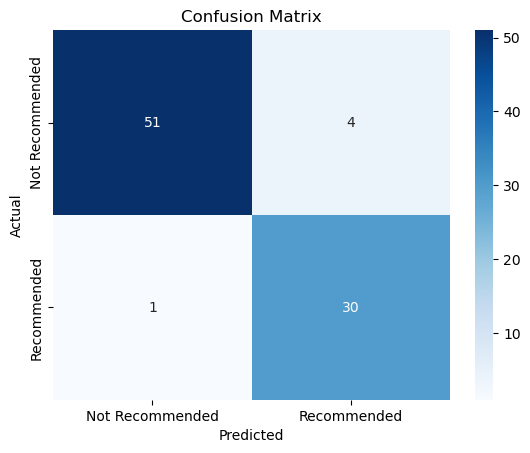

In [39]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Recommended", "Recommended"], 
            yticklabels=["Not Recommended", "Recommended"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# RESULTS:
# True Negatives (TN): 51 (Correctly predicted as Not Recommended)
# False Positives (FP): 4 (Incorrectly predicted as Recommended)
# False Negatives (FN): 1 (Incorrectly predicted as Not Recommended)
# True Positives (TP): 30 (Correctly predicted as Recommended)

# The confusion matrix suggests that the model is effectively identifying both classes with a low rate of false negatives (FN), indicating that a strong capability to recognize Recommended services.

In [42]:


# Calculate AUC-ROC for better insight
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.98


In [ ]:
# ROC AUC Score: A score of 0.98 demonstrates that the model has excellent discriminatory ability between classes, indicating a high likelihood that it ranks positive instances higher than negative ones.

In [46]:
# Making predictions on the whole dataset
full_predictions = best_model.predict(features)

In [49]:
# Adding predictions to the original dataset for analysis
OpenFile['Predicted Recommended Service'] = full_predictions

In [52]:
# Display the updated dataset with predictions
print(OpenFile[['Id', 'Review Title', 'Predicted Recommended Service']])

      Id                        Review Title  Predicted Recommended Service
0      1       Not the best customer service                              0
1      2     Worst business class experience                              0
2      3            the toilets became dirty                              0
3      4                  Worst service ever                              0
4      5        service fell painfully short                              0
..   ...                                 ...                            ...
423  424  Ethiopian Airlines customer review                              0
424  425  Ethiopian Airlines customer review                              0
425  426  Ethiopian Airlines customer review                              0
426  427  Ethiopian Airlines customer review                              0
427  428  Ethiopian Airlines customer review                              1

[428 rows x 3 columns]
